# **A simple model to study ventricular-arterial interactions**

In this jupyter notebook, we will couple a time-varying elastance model of the ventricle to a lumped parameter model of the arterial circuation. The example is worked out for the 2-element windkessel model.

Author: dr. ir. Mathias Peirlinck 


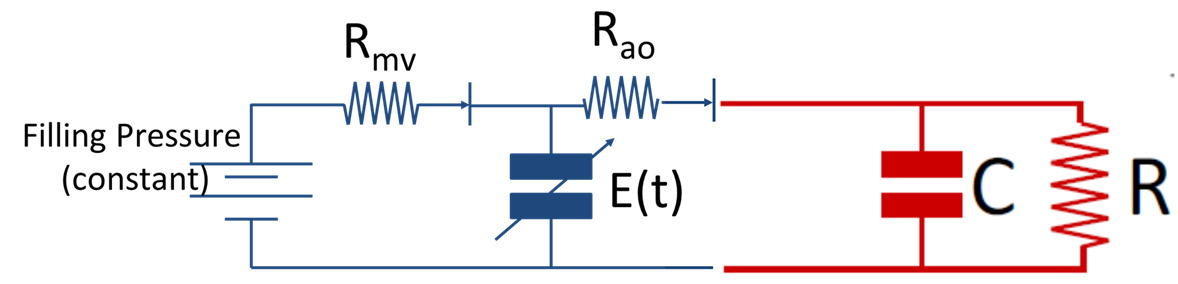

In [1]:
import numpy as np
import pandas as pd
from numpy import diff
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Governing equations

The system shown above can be solved using a combination of ordinary differential equations and algebraic equations. The model will be tuned to the left ventricle (LV), coupled to the aorta and systemic curculation. Obviously, the model arameters can be tuned to represent the right ventricle and pulmonary artery. 
Variables:
<br>VLV: LV volume (in ml)
<br>PLV: LV pressure (in mmHg)
<br>Qao: aortic flow (in ml/s)
<br>Pao: aortic pressure (in mmHg)
<br>Qmv: transmitral flow (in ml/s)

The mitral and aortic valve are modelled as simple resistors, with resistance Rmv and Rao, respectively. To allow for backflow through these valves, separate values for forward and backward flow will be used.   

It is further assumed that the filling pressure of the left atrium is constant, given by Pfilling.


### 1) Conservation of mass for the LV: 
$\frac{dVLV}{dt}=Qmv-Qao$
the change in LV volume equals inflow minus outflow
### 2) Conservation of mass for the 2-element WK model (see lecture slides): 
$\frac{dPao}{dt}=\frac{Qao}{C}-\frac{Pao}{RC}$
In fact, all other variables can be calculated by means of algebraic equations:<br>
### 3) PLV from VLV and E(t)
PLV is directly coupled to VLV through the time varying elastance function, with <br>$E(t)=\frac{PLV(t)}{VLV(t)-V0}$
### 4) Qmv from filling pressure and LV pressure
$Qmv=\frac{Pfilling - PLV(t)}{Rmv}$
### 4) Qao from LV and aortic pressure  
$Qao=\frac{PLV(t)-Pao(t)}{Rao}$


In [15]:
# set model parameters
# Cardiac parameters
Emax=2                    #mmHg/ml; slope of the ESPVR
V0=20                     #ml; intercept with volume axis of the ESPVR
Pfilling=5                #mmHg; venous filling pressure
EDV=120                   #ml; end-diastolic volume. We will use EDV with Pvenous to calculate Emin
Emin=Pfilling/(EDV-V0)    #mmHg/ml
HR=60                     #heart rate in beats/min

# Valve resistances
Rmv_fwd=0.002             #mmHg/ml/s; resistance in forward flow direction
Rmv_bwd=1e10              #mmHg/ml/s; leak resistance
Rao_fwd=0.002             #mmHg/ml/s; resistance in forward flow direction
Rao_bwd=1e10              #mmHg/ml/s; leak resistance

# Arterial model parameters
R_WK2=1                   #mmHg/ml/s
C_WK2=2                   #ml/mmHg


# Time-varying elastance function E(t)

First, we model how LV pressure relates to LV volume, which can be done using a time-varying elastance function. There are different ways to analytically describe this relation; we will make use of a Double Hill function inspired by Stergiopulos et al. (DOI:10.1152/ajpheart.1996.270.6.H2050)with a minor modification. 

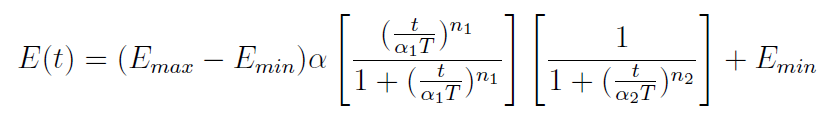


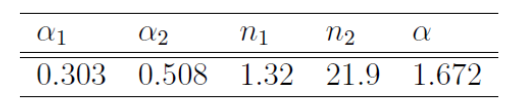


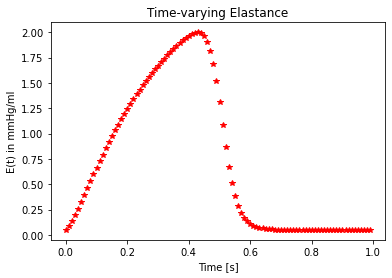

In [16]:
#Time-varying elastance function
def Elastance(HR,Emin,Emax,time):
  # calculates elastance for one heart cycle and teruns the value at an instant within the cardiac cycle
  # so time is maximally the end of the heart cycle
  a1 = 0.303         
  a2 = 0.508         
  n1 = 1.32
  n2 = 21.9
  T=60/HR
  tcycle=np.arange(0,60/HR,0.01)  #to normalize the shape of the elastance function, we need to calculate it over a complete cycle 
  term1_cycle=(tcycle/a1*T)**n1/(1+(tcycle/a1*T)**n1) 
  term2_cycle=1/(1+(tcycle/(a2*T))**n2)  
  term1=(time/a1*T)**n1/(1+(time/a1*T)**n1) 
  term2=1/(1+(time/(a2*T))**n2)  
  E_t=(Emax-Emin)*term1*term2/np.max(term1_cycle*term2_cycle)+Emin   #this formulation ensures that Emin and Emax always get the desired value 
  return time,E_t  

time=np.arange(0,60/HR,0.01) 
test=Elastance(HR,Emin,Emax,time)
plt.title('Time-varying Elastance')
plt.plot(test[0],test[1],'r*')
plt.xlabel('Time [s]')
plt.ylabel('E(t) in mmHg/ml')
plt.show()

With this elastance function, we can now write a function that calculates PLV from VLV

In [37]:
def computePLV(t,V):
    # calculate PLV from elastance and volume
    # input can be time array as well as a single instant in time
    global Emin,Emax,V0,HR
    Tcycle=60/HR
    t=t-np.floor(t/Tcycle)*Tcycle
    E_t=Elastance(HR,Emin,Emax,t)
    PLV=E_t[1]*(V-V0)
    return PLV

For now, we cannot couple the volume changes in our pump without explicitly prescribing in- and outflow rates. These rates can be automatically computed by coupling our ventrcile model to a closed-loop lumped parameter network (LPN).

## Coupling the heart to a 2-element Windkessel model

Below, we develop the code to compute our variables, pressure and volume in the ventricle, transmitral and aortic flow and aortic pressure, and this for multiple cardiac cycles starting from an initial value.

In summary, the following code snippet sets forth a function called *computeRates* which defines the differential equations ("rates") for the volume in the ventricle ("rates[0]") and the volume in the aorta ("rates[1]"). 

These rates are computed based on the instantaneous pressure in the ventricle ("algebraic[0]"), which is governed by the time-varying elastance function we defined before, and the instantaneous pressure in the aorta ("algebraic[1]"). These pressures lead to flows Q1 ("algebraic[2]") from the ventricle to the aorta, and flow Q2 from the aorta to the ventricle ("algebraic[3]"). To incorporate valves between the ventricle and the aorta on the one hand (aortic valve), and block regurgitant flow to the aorta, we enforce forward flows Q1 and Q2 only.

To solve this system of equations throughout multiple timesteps, we subsequently use an ODE solver and store the states and algebraics over time, so we can plot them afterwards.

In [48]:
from IPython.core.debugger import set_trace

# Size of variable arrays:
sizeAlgebraic = 3  # 3 algebraic equations to calculate PLV, Qmv, Qao
sizeStates = 2     # 2 differential equations: dVLV/dt and dPao/dt  
sizeConstants = 6  # Rmvfwd,Rmvbwd,Raofwd,Raobwd,R,C
constants=[0.0]*sizeConstants

constants[0]=Rmv_fwd
constants[1]=Rmv_bwd
constants[2]=Rao_fwd
constants[3]=Rao_bwd
constants[4]=R_WK2
constants[5]=C_WK2


# states holds values of VLV and Pao
# rates holds the derivatives of VLV and Pao

def computeRates(toi, states, constants):    # set up differential equations
    rates = [0.0] * sizeStates               # VLV, Pao
    algebraic = [0.0] * sizeAlgebraic        # PLV, Qmv, Qao
    global Pfilling                          # filling pressure is passed 
    
    #first calculate PLV from elastance and VLV 
    algebraic[0] = computePLV(toi,states[0])                                        

    #calculate Qmv
    if Pfilling>algebraic[0]:    #Pfilling>PLV; forward transmitral flow 
       algebraic[1] = (Pfilling-algebraic[0])/constants[0]
    else:                        #PLV>Pfilling - backward transmitral flow
       algebraic[1] = (algebraic[0]-Pfilling)/constants[1]                   

    #calculate Qao               #PLV>Pao; forward aortic flow
    if algebraic[0] > states[1]:
      algebraic[2] = (algebraic[0]-states[1])/constants[2]                   
    else:                        #PLV>Pao; backward aortic flow
      algebraic[2] = (states[1]-algebraic[0])/constants[3]                   

   
    rates[0]=algebraic[1]-algebraic[2]                                        #dVLV/dt=Qmv-Qao                                  
    rates[1]=algebraic[2]/constants[5]-states[1]/(constants[4]*constants[5])  #dPao/dt=Qao/C-Pao/RC

    return rates

def computeAlgebraic(toi, states, constants):
    algebraic = np.array([[0.0] * len(toi)] * sizeAlgebraic)
    states = np.array(states)
    toi = np.array(toi)

    #print(toi)
    #print(states[0])
    algebraic[0] = computePLV(toi,states[0])                                        # P_LV = f(V_LV) = Pelast(t,V_LV)

    
    for (i,t) in enumerate(toi):
        if Pfilling>algebraic[0,i]:    #Pfilling>PLV; forward transmitral flow 
           algebraic[1,i] = (Pfilling-algebraic[0,i])/constants[0]
        else:                        #PLV>Pfilling - backward transmitral flow
           algebraic[1,i] = (algebraic[0,i]-Pfilling)/constants[1]                   
        #calculate Qao               #PLV>Pao; forward aortic flow
        if algebraic[0,i] > states[1,i]:
           algebraic[2,i] = (algebraic[0,i]-states[1,i])/constants[2]                   
        else:                        #PLV>Pao; backward aortic flow
           algebraic[2,i] = (states[1,i]-algebraic[0,i])/constants[3]         

    return algebraic

def solve_model():
    """Solve model with ODE solver"""
    from scipy.integrate import ode
    
    global EDV
    
    # Initialise constants and state variables
    init_states = [0.0] * sizeStates
    init_states[0] = EDV                      #start with EDV 
    init_states[1] = 500                      #start with Pao at 50mmHg
    
    # Set timespan to solve over
    toi = np.linspace(0, 10, 1001)

    # Construct ODE object to solve
    r = ode(computeRates)
    r.set_integrator('vode', method='bdf', atol=1e-06, rtol=1e-06, max_step=1)
    r.set_initial_value(init_states, toi[0])
    r.set_f_params(constants)

    # Solve model
    states = np.array([[0.0] * len(toi)] * sizeStates)
    states[:,0] = init_states
    for (i,t) in enumerate(toi[1:]):
        if r.successful():
            r.integrate(t)
            states[:,i+1] = r.y
        else:
            break

    # Compute algebraic variables
    algebraic = computeAlgebraic(toi, states, constants)
    return (toi, states, algebraic)

(toi, states, algebraic) = solve_model()

Now that we solved this 3-element WK model, we can plot the pressure evolutions during multiple cardiac cycles.
Notice how fast the system of equations finds a stable solution starting from the assumed initial ventricular and aortic volumes.

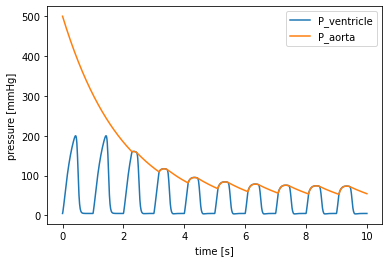

In [49]:
plt.plot(toi,algebraic[0],label='P_ventricle')
plt.plot(toi,states[1],label='P_aorta')
plt.xlabel('time [s]')
plt.ylabel('pressure [mmHg]')
plt.legend(loc='best')
plt.show()

## A minimal hemodynamic system model of the cardiovascular circulation

In this section, we will use a more complex lumped parameter network (LPN) to study some intrinsic behaviors of the human heart that we covered in class. 

The LPN we will be using is based on [research done by Smith et al.](https://doi.org/10.1016/j.medengphy.2003.10.001) and is depicted below. This LPN comprises 6 elastic chambers:
- the left ventricle
- the aorta
- the vena cava
- the right ventricle
- the pulmunary arteries
- the pulmonary veins

and includes effects of ventricular interaction and valve dynamics on the blood flow circulation.

Similar to the 3-element WK model we saw before, we can set up a system of ordinary differential equations (ODEs) to compute the time evolution of pressure and volume in each of these chambers.

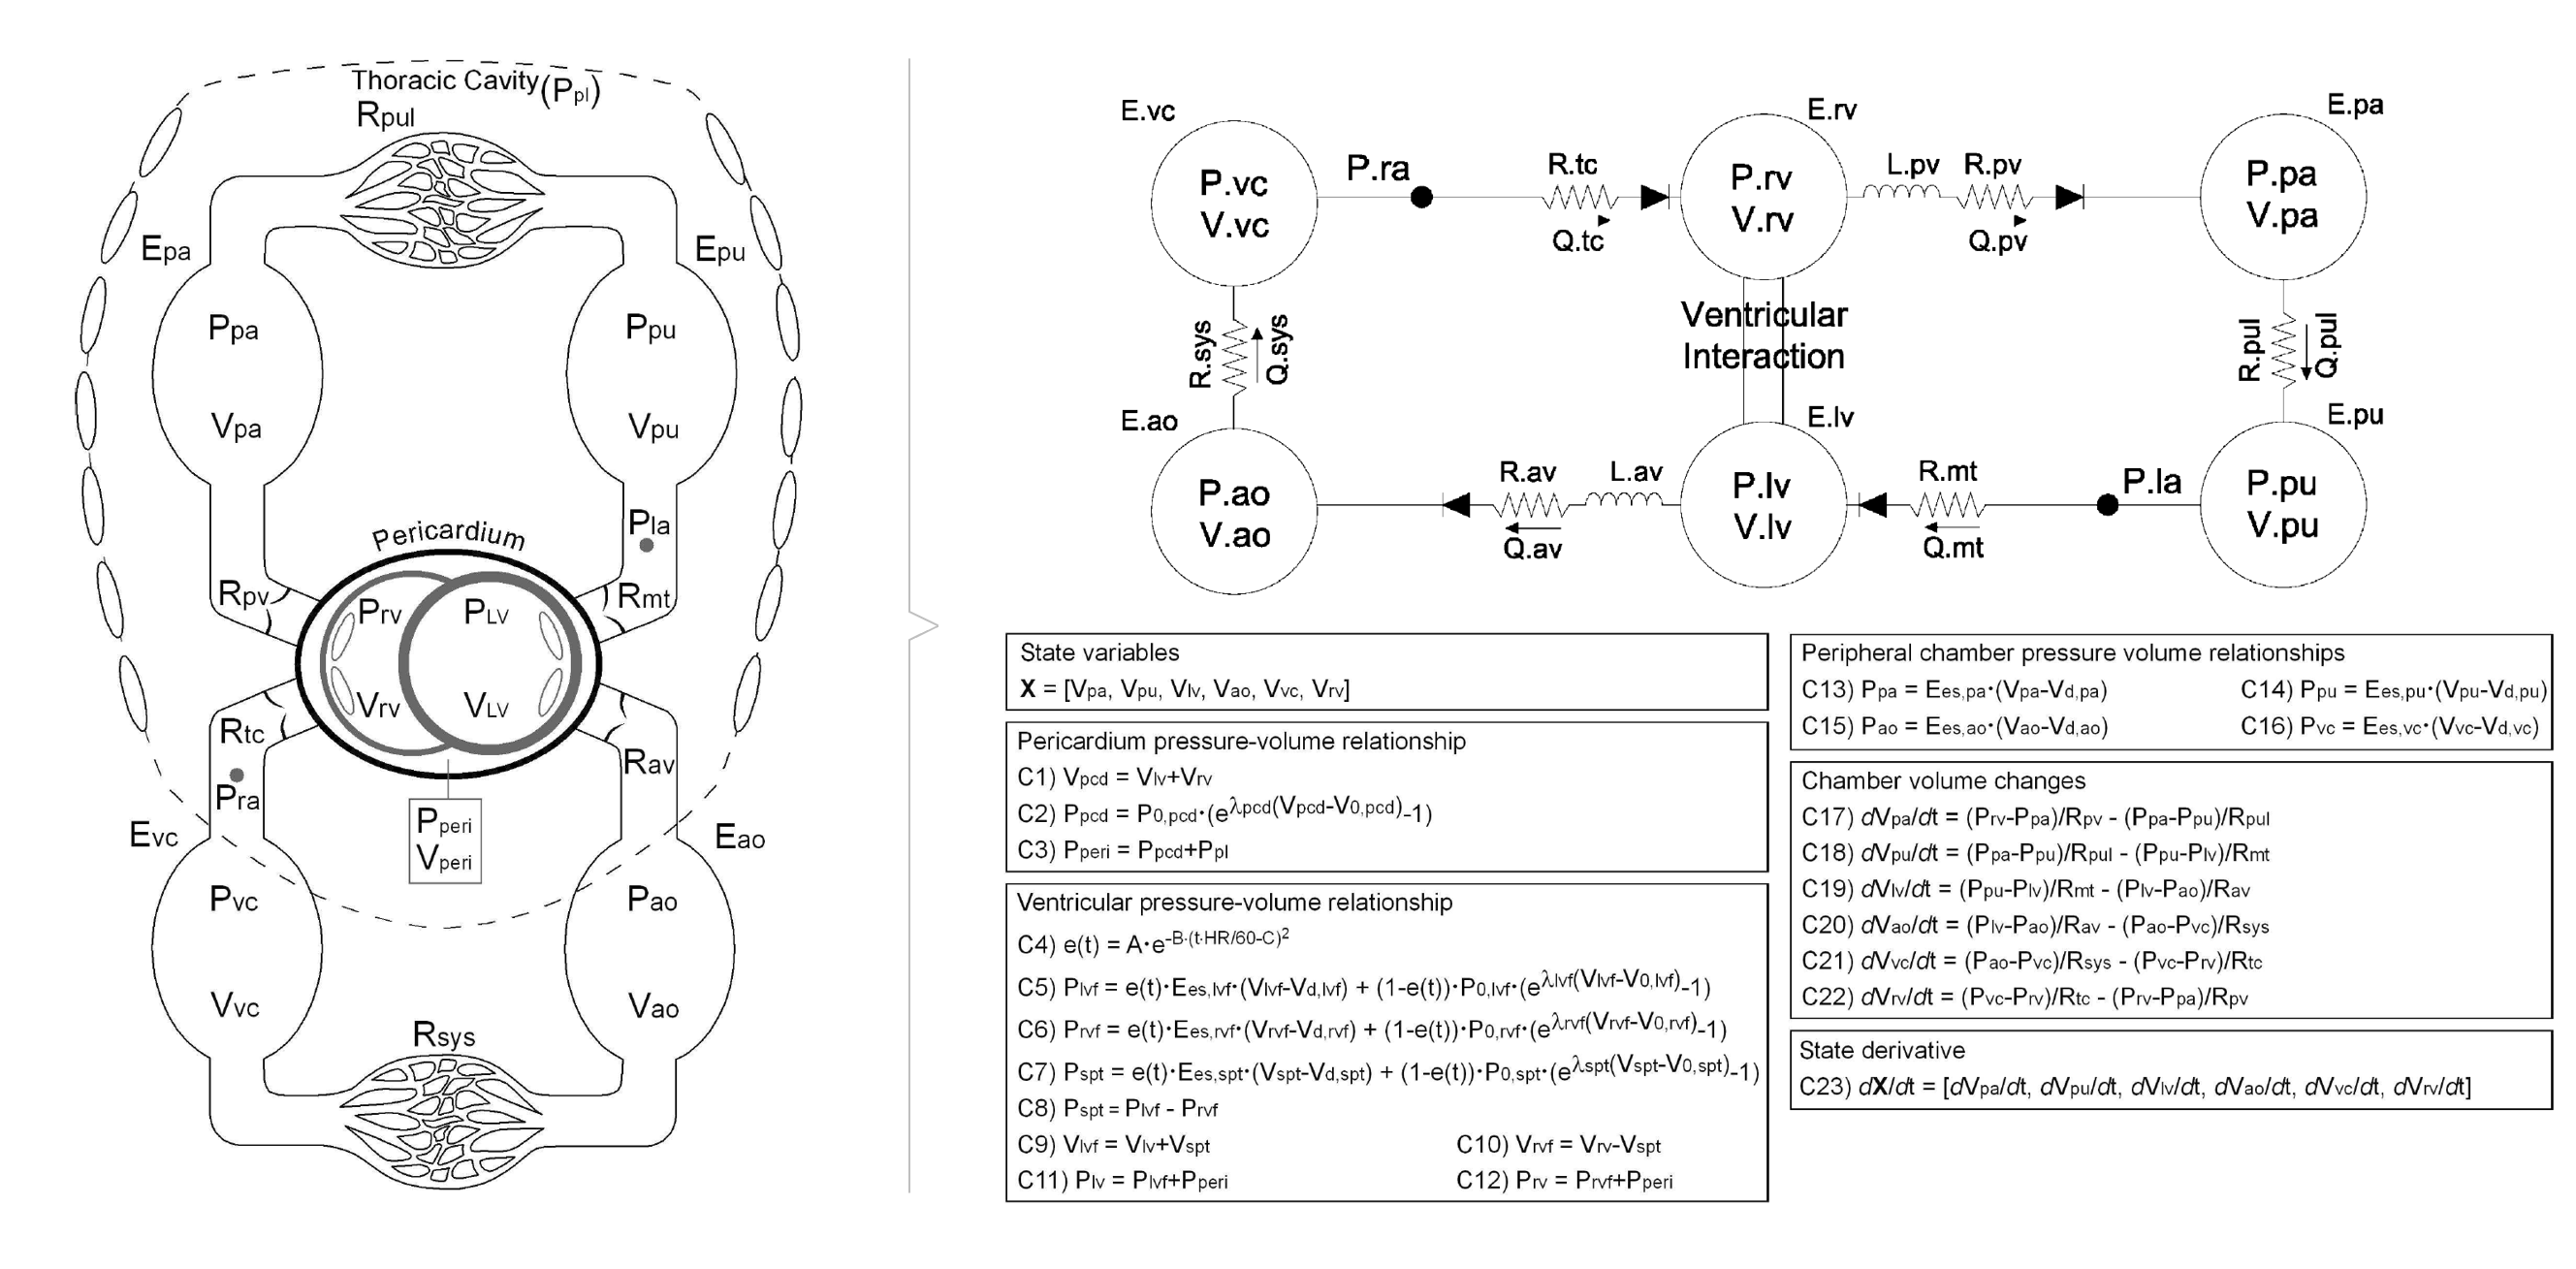

The following code snippet summarizes and implements the derivation of this system of equations. Here, it is not the goal for you to understand this whole derivation, so feel free to just execute this snippet without giving it too much in-depth attention. If you, however, want more information on the derivation and implementation of this specific LPN, we encourage you to consult the original article by Smith et al.

In [ ]:
# Size of variable arrays:
sizeAlgebraic = 22
sizeStates = 10
sizeConstants = 43
from math import *
from numpy import *

def initConsts():
    constants = [0.0] * sizeConstants; states = [0.0] * sizeStates;
 
    constants[0] = 0.0158                    	# "R_mt in component heart_parameters (kPa_second_per_mL)"
    constants[1] = 0.0180                    	# "R_av in component heart_parameters (kPa_second_per_mL)"
    constants[2] = 0.0237                    	# "R_tc in component heart_parameters (kPa_second_per_mL)"
    constants[3] = 0.0055                    	# "R_pv in component heart_parameters (kPa_second_per_mL)"
    constants[4] = 0.1552                    	# "R_pul in component heart_parameters (kPa_second_per_mL)"
    constants[5] = 1.0889                   	# "R_sys in component heart_parameters (kPa_second_per_mL)"
    constants[6] = 8.0093e-5                  # "L_tc in component heart_parameters (kPa_second2_per_mL)"
    constants[7] = 1.4868e-4                  # "L_pv in component heart_parameters (kPa_second2_per_mL)"
    constants[8] = 7.6968e-5                  # "L_mt in component heart_parameters (kPa_second2_per_mL)"
    constants[9] = 1.2189e-4                  # "L_av in component heart_parameters (kPa_second2_per_mL)"
    constants[10] = 5.5                    		# "V_tot in component heart_parameters (mL)"
    constants[11] = -4                    		# "P_th in component heart_parameters (kPa)"
    constants[12] = 1                    			# "A in component driver_function (dimensionless)"
    constants[13] = 80                    		# "B in component driver_function (per_second2)"
    constants[14] = 0.375                    	# "C in component driver_function (second)"
    constants[15] = 0.75                    	# "period in component driver_function (second)"
    constants[16] = 0.5003                    # "P_0_pcd in component pericardium (kPa)"
    constants[17] = 200                    		# "V_0_pcd in component pericardium (mL)"
    constants[18] = 0.03                    	# "lambda_pcd in component pericardium (per_mL)"
    constants[19] = 2.8798                    # "E_es_lvf in component lvf_calculator (kPa_per_mL)"
    constants[20] = 0.033                    	# "lambda_lvf in component lvf_calculator (per_mL)"
    constants[21] = 0.1203                    # "P_0_lvf in component lvf_calculator (kPa)"
    constants[22] = 0                    			# "V_d_lvf in component lvf_calculator (mL)"
    constants[23] = 0                    			# "V_0_lvf in component lvf_calculator (mL)"
    constants[24] = 0.585                    	# "E_es_rvf in component rvf_calculator (kPa_per_mL)"
    constants[25] = 0.023                    	# "lambda_rvf in component rvf_calculator (per_mL)"
    constants[26] = 0.2157                    # "P_0_rvf in component rvf_calculator (kPa)"
    constants[27] = 0                    			# "V_d_rvf in component rvf_calculator (mL)"
    constants[28] = 0                    			# "V_0_rvf in component rvf_calculator (mL)"
    constants[29] = 48.754                    # "E_es_spt in component septum (kPa_per_mL)"
    constants[30] = 2                    			# "V_d_spt in component septum (mL)"
    constants[31] = 1.1101                    # "P_0_spt in component septum (kPa)"
    constants[32] = 0.435                    	# "lambda_spt in component septum (per_mL)"
    constants[33] = 2                    			# "V_0_spt in component septum (mL)"
    constants[34] = 1                    			# "one in component septum (dimensionless)"
    constants[35] = 0.369                    	# "E_es_pa in component pulmonary_artery (kPa_per_mL)"
    constants[36] = 0                    			# "V_d_pa in component pulmonary_artery (mL)"
    constants[37] = 0.0073                    # "E_es_pu in component pulmonary_vein (kPa_per_mL)"
    constants[38] = 0                    			# "V_d_pu in component pulmonary_vein (mL)"
    constants[39] = 0.6913                    # "E_es_ao in component aorta (kPa_per_mL)"
    constants[40] = 0                    			# "V_d_ao in component aorta (mL)"
    constants[41] = 0.0059                    # "E_es_vc in component vena_cava (kPa_per_mL)"
    constants[42] = 0                    			# "V_d_vc in component vena_cava (mL)"

    states[0] = 94.6812                    		# "V_lv in component left_ventricle (mL)"
    states[1] = 90.7302                    		# "V_rv in component right_ventricle (mL)"
    states[2] = 245.5813                    	# "Q_mt in component flow (mL_per_second)"
    states[3] = 0                    					# "Q_av in component flow (mL_per_second)"
    states[4] = 190.0661                    	# "Q_tc in component flow (mL_per_second)"
    states[5] = 0                    					# "Q_pv in component flow (mL_per_second)"
    states[6] = 43.0123                    		# "V_pa in component pulmonary_artery (mL)"
    states[7] = 808.4579                    	# "V_pu in component pulmonary_vein (mL)"
    states[8] = 133.3381                    	# "V_ao in component aorta (mL)"
    states[9] = 329.7803                    	# "V_vc in component vena_cava (mL)"

    return (states, constants)

def computeRates(toi, states, constants):
    rates = [0.0] * sizeStates; algebraic = [0.0] * sizeAlgebraic
    rates[0] = custom_piecewise([less(states[2] , 0.00000) & less(states[3] , 0.00000), 0.00000 , less(states[2] , 0.00000), -states[3] , less(states[3] , 0.00000), states[2] , True, states[2]-states[3]])
    rates[1] = custom_piecewise([less(states[4] , 0.00000) & less(states[5] , 0.00000), 0.00000 , less(states[4] , 0.00000), -states[5] , less(states[5] , 0.00000), states[4] , True, states[4]-states[5]])
    algebraic[2] = states[0]+states[1]
    algebraic[3] = constants[16]*(exp(constants[18]*(algebraic[2]-constants[17]))-1.00000)
    algebraic[4] = algebraic[3]+constants[11]
    algebraic[0] = custom_piecewise([less_equal(toi , constants[15]), toi , less_equal(toi , constants[15]*2.00000), toi-constants[15] , less_equal(toi , constants[15]*3.00000), toi-constants[15]*2.00000 , less_equal(toi , constants[15]*4.00000), toi-constants[15]*3.00000 , less_equal(toi , constants[15]*5.00000), toi-constants[15]*4.00000 , less_equal(toi , constants[15]*6.00000), toi-constants[15]*5.00000 , less_equal(toi , constants[15]*7.00000), toi-constants[15]*6.00000 , less_equal(toi , constants[15]*8.00000), toi-constants[15]*7.00000 , less_equal(toi , constants[15]*9.00000), toi-constants[15]*8.00000 , less_equal(toi , constants[15]*10.0000), toi-constants[15]*9.00000 , less_equal(toi , constants[15]*11.0000), toi-constants[15]*10.0000 , less_equal(toi , constants[15]*12.0000), toi-constants[15]*11.0000 , less_equal(toi , constants[15]*13.0000), toi-constants[15]*12.0000 , True, float('nan')])
    algebraic[1] = constants[12]*exp(-constants[13]*(power(algebraic[0]-constants[14], 2.00000)))
    algebraic = rootfind_0(toi, constants, states, algebraic)
    algebraic[6] = states[0]-algebraic[5]
    algebraic[7] = constants[19]*(algebraic[6]-constants[22])
    algebraic[8] = constants[21]*(exp(constants[20]*(algebraic[6]-constants[23]))-1.00000)
    algebraic[9] = algebraic[1]*algebraic[7]+(1.00000-algebraic[1])*algebraic[8]
    algebraic[10] = algebraic[9]+algebraic[4]
    algebraic[17] = constants[39]*(states[8]-constants[40])
    rates[3] = custom_piecewise([less(algebraic[10]-algebraic[17] , 0.00000) & less(states[3] , 0.00000), 0.00000 , True, ((algebraic[10]-algebraic[17])-states[3]*constants[1])/constants[9]])
    algebraic[11] = states[1]+algebraic[5]
    algebraic[12] = constants[24]*(algebraic[11]-constants[27])
    algebraic[13] = constants[26]*(exp(constants[25]*(algebraic[11]-constants[28]))-1.00000)
    algebraic[14] = algebraic[1]*algebraic[12]+(1.00000-algebraic[1])*algebraic[13]
    algebraic[15] = algebraic[14]+algebraic[4]
    algebraic[16] = constants[35]*(states[6]-constants[36])+constants[11]
    rates[5] = custom_piecewise([less(algebraic[15]-algebraic[16] , 0.00000) & less(states[5] , 0.00000), 0.00000 , True, ((algebraic[15]-algebraic[16])-states[5]*constants[3])/constants[7]])
    algebraic[18] = constants[37]*(states[7]-constants[38])+constants[11]
    rates[2] = custom_piecewise([less(algebraic[18]-algebraic[10] , 0.00000) & less(states[2] , 0.00000), 0.00000 , True, ((algebraic[18]-algebraic[10])-states[2]*constants[0])/constants[8]])
    algebraic[19] = constants[41]*(states[9]-constants[42])
    rates[4] = custom_piecewise([less(algebraic[19]-algebraic[15] , 0.00000) & less(states[4] , 0.00000), 0.00000 , True, ((algebraic[19]-algebraic[15])-states[4]*constants[2])/constants[6]])
    algebraic[20] = (algebraic[16]-algebraic[18])/constants[4]
    rates[6] = custom_piecewise([less(states[5] , 0.00000), -algebraic[20] , True, states[5]-algebraic[20]])
    rates[7] = custom_piecewise([less(states[2] , 0.00000), algebraic[20] , True, algebraic[20]-states[2]])
    algebraic[21] = (algebraic[17]-algebraic[19])/constants[5]
    rates[8] = custom_piecewise([less(states[3] , 0.00000), -algebraic[21] , True, states[3]-algebraic[21]])
    rates[9] = custom_piecewise([less(states[4] , 0.00000), algebraic[21] , True, algebraic[21]-states[4]])
    return(rates)

def computeAlgebraic(constants, states, toi):
    algebraic = array([[0.0] * len(toi)] * sizeAlgebraic)
    states = array(states)
    toi = array(toi)
    algebraic[2] = states[0]+states[1]
    algebraic[3] = constants[16]*(exp(constants[18]*(algebraic[2]-constants[17]))-1.00000)
    algebraic[4] = algebraic[3]+constants[11]
    algebraic[0] = custom_piecewise([less_equal(toi , constants[15]), toi , less_equal(toi , constants[15]*2.00000), toi-constants[15] , less_equal(toi , constants[15]*3.00000), toi-constants[15]*2.00000 , less_equal(toi , constants[15]*4.00000), toi-constants[15]*3.00000 , less_equal(toi , constants[15]*5.00000), toi-constants[15]*4.00000 , less_equal(toi , constants[15]*6.00000), toi-constants[15]*5.00000 , less_equal(toi , constants[15]*7.00000), toi-constants[15]*6.00000 , less_equal(toi , constants[15]*8.00000), toi-constants[15]*7.00000 , less_equal(toi , constants[15]*9.00000), toi-constants[15]*8.00000 , less_equal(toi , constants[15]*10.0000), toi-constants[15]*9.00000 , less_equal(toi , constants[15]*11.0000), toi-constants[15]*10.0000 , less_equal(toi , constants[15]*12.0000), toi-constants[15]*11.0000 , less_equal(toi , constants[15]*13.0000), toi-constants[15]*12.0000 , True, float('nan')])
    algebraic[1] = constants[12]*exp(-constants[13]*(power(algebraic[0]-constants[14], 2.00000)))
    algebraic = rootfind_0(toi, constants, states, algebraic)
    algebraic[6] = states[0]-algebraic[5]
    algebraic[7] = constants[19]*(algebraic[6]-constants[22])
    algebraic[8] = constants[21]*(exp(constants[20]*(algebraic[6]-constants[23]))-1.00000)
    algebraic[9] = algebraic[1]*algebraic[7]+(1.00000-algebraic[1])*algebraic[8]
    algebraic[10] = algebraic[9]+algebraic[4]
    algebraic[17] = constants[39]*(states[8]-constants[40])
    algebraic[11] = states[1]+algebraic[5]
    algebraic[12] = constants[24]*(algebraic[11]-constants[27])
    algebraic[13] = constants[26]*(exp(constants[25]*(algebraic[11]-constants[28]))-1.00000)
    algebraic[14] = algebraic[1]*algebraic[12]+(1.00000-algebraic[1])*algebraic[13]
    algebraic[15] = algebraic[14]+algebraic[4]
    algebraic[16] = constants[35]*(states[6]-constants[36])+constants[11]
    algebraic[18] = constants[37]*(states[7]-constants[38])+constants[11]
    algebraic[19] = constants[41]*(states[9]-constants[42])
    algebraic[20] = (algebraic[16]-algebraic[18])/constants[4]
    algebraic[21] = (algebraic[17]-algebraic[19])/constants[5]
    return algebraic

initialGuess0 = None
def rootfind_0(toi, constants, states, algebraic):
    """Calculate value of algebraic variable for DAE"""
    from scipy.optimize import fsolve
    global initialGuess0
    if (initialGuess0 == None): initialGuess0 = 0.1
    if not iterable(toi):
        algebraic[5] = fsolve(residualSN_0, initialGuess0, args=(algebraic, toi, constants, states), xtol=1E-6)
        initialGuess0 = algebraic[5]
    else:
        for (i,t) in enumerate(toi):
            algebraic[5][i] = fsolve(residualSN_0, initialGuess0, args=(algebraic[:,i], toi[i], constants, states[:,i]), xtol=1E-6)
            initialGuess0 = algebraic[5][i]
    return algebraic

def residualSN_0(algebraicCandidate, algebraic, toi, constants, states):
    algebraic[5] = algebraicCandidate
    return (0.00000) - ((((algebraic[1]*constants[29]*(algebraic[5]-constants[30])+(constants[34]-algebraic[1])*constants[31]*(exp(constants[32]*(algebraic[5]-constants[33]))-constants[34]))-algebraic[1]*constants[19]*(states[0]-algebraic[5]))-(1.00000-algebraic[1])*constants[21]*(exp(constants[20]*(states[0]-algebraic[5]))-1.00000))+algebraic[1]*constants[24]*(states[1]+algebraic[5])+(1.00000-algebraic[1])*constants[26]*(exp(constants[25]*(states[1]+algebraic[5]))-1.00000))

def custom_piecewise(cases):
    """Compute result of a piecewise function"""
    return select(cases[0::2],cases[1::2])

def solve_model(LPN_params=False):
    """Solve model with ODE solver"""
    from scipy.integrate import ode
    # Initialise constants and state variables
    (init_states, constants) = initConsts()
    # Allow user to update the LPN parameters
    if LPN_params:                       
        constants=LPN_params

    # Set timespan to solve over
    toi = linspace(0, 7.5, 750)

    # Construct ODE object to solve
    r = ode(computeRates)
    r.set_integrator('vode', method='bdf', atol=1e-06, rtol=1e-06, max_step=1)
    r.set_initial_value(init_states, toi[0])
    r.set_f_params(constants)

    # Solve model
    states = array([[0.0] * len(toi)] * sizeStates)
    states[:,0] = init_states
    for (i,t) in enumerate(toi[1:]):
        if r.successful():
            r.integrate(t)
            states[:,i+1] = r.y
        else:
            break

    # Compute algebraic variables
    algebraic = computeAlgebraic(constants, states, toi)
    return (toi, states, algebraic)

### Baseline model
Now that we implemented this LPN, we can solve the baseline case first, and plot the time evolution of both volume and pressure in different sections of the cardiovascular system.

In [ ]:
def PV_output(states,algebraic):
    # function to extract volumes and pressure evolution expressed in ml and mmHg (frequently used units in clinical settings)
    V_lv = states[0]
    P_lv = algebraic[10]
    V_rv = states[1]
    P_rv = algebraic[15]
    P_ao = algebraic[17]
    P_pv = algebraic[18]
    P_pa = algebraic[16]
    P_vc = algebraic[19]
    
    return V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc

In [ ]:
# baseline model, keep original parameter values
(toi, states, algebraic) = solve_model()

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(states,algebraic)

In [ ]:
# Plot left vs right heart - Volume and Pressure vs Time
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=2,sharey='row',sharex=True)
ax=ax.flatten()

ax[0].plot(toi,V_lv,label='V_lv')
ax[0].set_title('Left Ventricle')
ax[1].plot(toi,V_rv,label='V_rv')
ax[1].set_title('Right Ventricle')
ax[0].set_ylabel('Volume [ml]')

for i in range(0,2):
    ax[i].legend(loc='best',frameon=False)

ax[2].plot(toi,P_lv,label='P_lv')
ax[2].plot(toi,P_ao,label='P_ao')
ax[2].plot(toi,P_pv,label='P_pv')

ax[3].plot(toi,P_rv,label='P_rv')
ax[3].plot(toi,P_pa,label='P_pa')
ax[3].plot(toi,P_vc,label='P_vc')
ax[2].set_ylabel('Pressure [mmHg]')

for i in range(2,4):
    ax[i].set_xlabel('Time [s]')
    # ax[i].set_ylabel('Pressure [mmHg]')
    ax[i].legend(loc='best',frameon=False)

fig.tight_layout()
plt.show()


Let's focus on the last two heart cycles. 

Notice the resemblance between these results and the Wigger's diagram we discussed during the lecture.

In [ ]:
HR = 80.              # heart rate
fpb = 100/(HR/60.)    # frames per beat, depends on the time linspace defined in solve_model
ftwo = int(2*fpb)     # amount of frames in last two beats

In [ ]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=2,sharey='row',sharex=True)
ax=ax.flatten()

ax[0].plot(toi[0:ftwo],V_lv[-ftwo:],label='V_lv')
ax[0].set_title('Left Ventricle')
ax[1].plot(toi[0:ftwo],V_rv[-ftwo:],label='V_rv')
ax[1].set_title('Right Ventricle')
ax[0].set_ylabel('Volume [ml]')

for i in range(0,2):
    ax[i].legend(loc='best',frameon=False)

ax[2].plot(toi[0:ftwo],P_lv[-ftwo:],label='P_lv')
ax[2].plot(toi[0:ftwo],P_ao[-ftwo:],label='P_ao')
ax[2].plot(toi[0:ftwo],P_pv[-ftwo:],label='P_pv')

ax[3].plot(toi[0:ftwo],P_rv[-ftwo:],label='P_rv')
ax[3].plot(toi[0:ftwo],P_pa[-ftwo:],label='P_pa')
ax[3].plot(toi[0:ftwo],P_vc[-ftwo:],label='P_vc')
ax[2].set_ylabel('Pressure [mmHg]')

for i in range(2,4):
    ax[i].set_xlabel('Time [s]')
    # ax[i].set_ylabel('Pressure [mmHg]')
    ax[i].legend(loc='best',frameon=False)

fig.tight_layout()
plt.show()

We can also plot the pressure-volume loops in the ventricles as follows:

In [ ]:
fig2,ax2 = plt.subplots(figsize=(10,5),nrows=1,ncols=2,sharey='row')
ax2=ax2.flatten()

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(states,algebraic)

ax2[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='baseline')
ax2[0].set_title('Left Ventricle')
ax2[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='baseline')
ax2[1].set_title('Right Ventricle')

for j in range(2):
  ax2[j].set_xlabel('Volume [ml]')
  ax2[j].legend(loc='best',frameon=False)
ax2[0].set_ylabel('Pressure [mmHg]')

fig2.tight_layout()
plt.show()

### Changing arterial stiffness

In the lecture, we discussed the independent effects of changing the preload, afterload and inotropy/contractility of the heart. In reality, most of these effects influence eachother concomitantly.

A classical example of these confounded effects is what happens to the increasing stiffness of our arterial system as we age. Here, we will show the effect of a changing arterial systemic stiffness, an effect that could be considered a changing afterload, but indirectly also leads to a changing preload of the heart.

Here we will simulate two cases and compare it to our baseline case:
- a decreased arterial stiffness (simulated by decreasing the systemic resistance to half the baseline parameter value)
- an increased arterial stiffness (simulated by increasing the systemic resistance to double the baseline parameter value)


In [ ]:
# constant 5 = parameter value for systemic resistance
(init_states, constants) = initConsts()
R_sys_base = constants[5]
R_sys_half = 0.5*R_sys_base
R_sys_double = 2.0*R_sys_base

fig3,ax3 = plt.subplots(figsize=(10,5),nrows=1,ncols=2,sharey='row')
ax3=ax3.flatten()

# let's first plot the baseline model
V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(states,algebraic)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='baseline')
ax3[0].set_title('Left Ventricle')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='baseline')
ax3[1].set_title('Right Ventricle')

# next, we compute the decreased arterial stiffness case
(init_states, constants) = initConsts()
LPN_params = constants
LPN_params[5] = R_sys_half
(toitmp, statestmp, algebraictmp) = solve_model(LPN_params=LPN_params)

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(statestmp,algebraictmp)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='R_sys_half')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='R_sys_half')

# next, we compute the increased arterial stiffness case
(init_states, constants) = initConsts()
LPN_params = constants
LPN_params[5] = R_sys_double
(toitmp, statestmp, algebraictmp) = solve_model(LPN_params=LPN_params)

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(statestmp,algebraictmp)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='R_sys_double')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='R_sys_double')

# Show plot
for j in range(2):
  ax3[j].set_xlabel('Volume [ml]')
  ax3[j].legend(loc='best',frameon=False)
ax3[0].set_ylabel('Pressure [mmHg]')

fig3.tight_layout()
plt.show()

Here, we notice the effect of a changing afterload, as we dicussed in the lecture. The end systolic pressure-volume relationship (ESPVR) can be found by connecting the far-left top corner pressure-volume relationships in the PV loops of all considered cases.

Given that we work in a coupled system, changing the afterload also affects the preload of the ventricle. Take some time to couple this back to the Frank-Starling mechanism taught in class, and how this concomitantly affects the changing stroke volume.

### Varying ventricular contractility

In a similar fashion, we can simulate the effect of changing inotropy of the heart (e.g deep rest versus exercise). 

Here we will simulate two cases and compare it to our baseline case:
- a decreased contractility (simulated by decreasing Ees, the parameter controlling the slope of the ESPVR-curve, to half its baseline parameter value)
- an increased contractility (simulated by inscreasing Ees, the parameter controlling the slope of the ESPVR-curve, to double its baseline parameter value)

In [ ]:
# constant 19 = parameter value for E_es_lvf
(init_states, constants) = initConsts()
E_es_lvf_base = constants[19]
E_es_lvf_half = 0.5*E_es_lvf_base
E_es_lvf_double = 2.0*E_es_lvf_base

# constant 21 = parameter value for E_es_rvf
E_es_rvf_base = constants[24]
E_es_rvf_half = 0.5*E_es_rvf_base
E_es_rvf_double = 2.0*E_es_rvf_base

# constant 26 = parameter value for E_es_rvf
E_es_spt_base = constants[29]
E_es_spt_half = 0.5*E_es_spt_base
E_es_spt_double = 2.0*E_es_spt_base

# constant 36 = parameter value for E_es_ao
E_es_ao_base = constants[34]
E_es_ao_half = 0.5*E_es_ao_base
E_es_ao_double = 2.0*E_es_ao_base

fig3,ax3 = plt.subplots(figsize=(10,5),nrows=1,ncols=2,sharey='row')
ax3=ax3.flatten()

# let's first plot the baseline model
V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(states,algebraic)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='baseline')
ax3[0].set_title('Left Ventricle')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='baseline')
ax3[1].set_title('Right Ventricle')

# next, we compute the decreased contractility
(init_states, constants) = initConsts()
LPN_params = constants
LPN_params[19] = E_es_lvf_half
LPN_params[24] = E_es_rvf_half
LPN_params[29] = E_es_spt_half
LPN_params[34] = E_es_ao_half
(toitmp, statestmp, algebraictmp) = solve_model(LPN_params=LPN_params)

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(statestmp,algebraictmp)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='E_es_half')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='E_es_half')

# next, we compute the increased contractility
(init_states, constants) = initConsts()
LPN_params = constants
LPN_params[19] = E_es_lvf_double
LPN_params[24] = E_es_rvf_double
LPN_params[29] = E_es_spt_double
LPN_params[34] = E_es_ao_double
(toitmp, statestmp, algebraictmp) = solve_model(LPN_params=LPN_params)

V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(statestmp,algebraictmp)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='E_es_double')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='E_es_double')

# Show plot
for j in range(2):
  ax3[j].set_xlabel('Volume [ml]')
  ax3[j].legend(loc='best',frameon=False)
ax3[0].set_ylabel('Pressure [mmHg]')

fig3.tight_layout()
plt.show()


Typically, increased contractility
- increases cardiac output
- shifts up the ESPVR-curve

Take some time to appreciate these trends in our produced plots.

### Simulating the response of the heart to specific therapies - example COVID-19 application

As mentioned in the lecture, modeling the human heart with calibrated and validated lumped parameter networks allows us to simulate the human heart function in response to changes in therapy.

As an example application, we can for example look how putting severe COVID-19 patients on mechanical ventilation affects their human heart function. During positive pressure mechanical ventilation, the thoracic pressure (which in normal conditions averages around -4mmHg) is increased to 0 mmHg. If we simulate this change in the LPN, we get:

In [ ]:
# constant 11 = parameter value for thoracic pressure
(init_states, constants) = initConsts()
P_th_base = constants[11]
P_th_mechvent = 0.

fig3,ax3 = plt.subplots(figsize=(10,5),nrows=1,ncols=2,sharey='row')
ax3=ax3.flatten()
# let's first plot the baseline model
V_lv, P_lv, V_rv, P_rv, P_ao, P_pv, P_pa, P_vc = PV_output(states,algebraic)

ax3[0].plot(V_lv[-ftwo:],P_lv[-ftwo:],label='baseline')
ax3[0].set_title('Left Ventricle')
ax3[1].plot(V_rv[-ftwo:],P_rv[-ftwo:],label='baseline')
ax3[1].set_title('Right Ventricle')

# next, we compute the response for a patient being put on mechanical ventilation
(init_states, constants) = initConsts()
LPN_params = constants
LPN_params[11] = P_th_mechvent
(toitmp, statestmp, algebraictmp) = solve_model(LPN_params=LPN_params)

V_lv_mv, P_lv_mv, V_rv_mv, P_rv_mv, P_ao_mv, P_pv_mv, P_pa_mv, P_vc_mv = PV_output(statestmp,algebraictmp)

ax3[0].plot(V_lv_mv[-ftwo//2-1:],P_lv_mv[-ftwo//2-1:],label='mechanical ventilation')
ax3[1].plot(V_rv_mv[-ftwo//2-1:],P_rv_mv[-ftwo//2-1:],label='mechanical ventilation')

# Show plot
for j in range(2):
  ax3[j].set_xlabel('Volume [ml]')
  ax3[j].legend(loc='best',frameon=False)
ax3[0].set_ylabel('Pressure [mmHg]')

fig3.tight_layout()
plt.show()

From both solutions, we can compute the relative change in stroke volume:



In [ ]:
SV_baseline = np.max(V_lv[-ftwo//2-1:])-np.min(V_lv[-ftwo//2-1:])
SV_mechvent = np.max(V_lv_mv[-ftwo//2-1:])-np.min(V_lv_mv[-ftwo//2-1:])
print(SV_mechvent/SV_baseline)

As can be seen from the solution, the stroke volume, and thus the cardiac output, drops about 10% in response to mechanical ventilation of the patient. This is consistent with clinical observations and, as such, provides some partial validation of the developed LPN.